# Description
This project is a part of my masters thesis. As a hoal I\d like to build effective recommendation system for footwear retail company ECCO Inc (I work there as a fullstack software engeneer). I'd like to investigate different approaches for such systems and find a most performant for company requirements.


## Data analysys and preparation

As dataset I took real data from few different markets. In first part I'd like to investigate data and prepare it for further processing. My initial idea is to take properties of products and combine it with some textual descriptions for each product and based on this buld the model.

First of all I'd like to merge all indexes I have to single dataset with unique items inside

In [20]:
import pandas as pd
import glob
file_path = './ECCO DATA/*.json'


all_files = glob.glob(file_path)
df_list = [pd.read_json(file) for file in all_files]

combined_df = pd.concat(df_list, ignore_index=True)

cleaned_df = combined_df.drop_duplicates(subset=['objectID'])

print(cleaned_df.info())
print(cleaned_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 3291 entries, 0 to 6714
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   articleNumber           3291 non-null   int64 
 1   image                   3276 non-null   object
 2   priceRaw                3291 non-null   object
 3   listPriceRaw            3291 non-null   object
 4   hasDiscount             3291 non-null   bool  
 5   colorCode               3291 non-null   int64 
 6   dominantColor           3278 non-null   object
 7   gender                  3290 non-null   object
 8   materialGroup           3291 non-null   object
 9   hierarchicalCategories  3291 non-null   object
 10  variants                3291 non-null   object
 11  name                    3291 non-null   object
 12  sizes                   3291 non-null   object
 13  factsAndBenefits        3291 non-null   object
 14  hasStock                3291 non-null   bool  
 15  descripti

We can see that for some products we have missing values. Also some of textual data (such as `factsAndBenefits` and others) has same value for different products, which could be an issue for our sistem,m but let;s check first hypothesis.

To go forward I'd like to keep only meaningful columns for the model

In [21]:
columns_to_keep = [
    'objectID',
    'name',
    'dominantColor',
    'gender',
    'materialGroup',
    'dominantMaterial',
    'occasion',
    'group',
    'descriptiveHeading',
    'factsAndBenefits',
    'image'
]

cleaned_df = cleaned_df[columns_to_keep]

print(f"Data after clean-up: {cleaned_df.shape}")
print(cleaned_df.info())
print(cleaned_df.head())


Data after clean-up: (3291, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 3291 entries, 0 to 6714
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   objectID            3291 non-null   int64 
 1   name                3291 non-null   object
 2   dominantColor       3278 non-null   object
 3   gender              3290 non-null   object
 4   materialGroup       3291 non-null   object
 5   dominantMaterial    2935 non-null   object
 6   occasion            3291 non-null   object
 7   group               3291 non-null   object
 8   descriptiveHeading  2059 non-null   object
 9   factsAndBenefits    3291 non-null   object
 10  image               3276 non-null   object
dtypes: int64(1), object(10)
memory usage: 308.5+ KB
None
       objectID                       name dominantColor      gender  \
0  910798091389     ECCO APPARITION MEDIUM          Pink  Genderless   
1  910797391382   ECCO UPCYCLED LARGE CA

In [62]:
output_path = "cleaned_data.csv"
columns_to_keep = [
    'objectID',
    'name',
    'dominantColor',
    'gender',
    'image'
]
df_save = combined_df[columns_to_keep]
df_save.to_csv(output_path, index=False)

## Using products features to get similarity

First of all I'd like to check some approach based on features of products. I'd like to analyze textual and categorical features and build some solution relying on them.
Let's prepare data 

In [22]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(["ecco"]) #I found that brand name included really often to different features, let's remove this to bring down a noise

def preprocess_text(text):
    if isinstance(text, list):
        text = " ".join(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

cleaned_df['processedFactsAndBenefits'] = cleaned_df['factsAndBenefits'].apply(preprocess_text)
cleaned_df['processedName'] = cleaned_df['name'].apply(preprocess_text)

#There are few items with empty `descriptiveHeading` prop
cleaned_df['descriptiveHeading'] = cleaned_df['descriptiveHeading'].fillna("")
cleaned_df['processedDescriptiveHeading'] = cleaned_df['descriptiveHeading'].apply(preprocess_text)

print("Text is processed")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text is processed


Let's vectorize texttual features

In [23]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

facts_vectorizer = TfidfVectorizer(max_features=500)
facts_text_features = facts_vectorizer.fit_transform(cleaned_df['processedFactsAndBenefits']).toarray()

name_vectorizer = TfidfVectorizer(max_features=400)
name_text_features = name_vectorizer.fit_transform(cleaned_df['processedName']).toarray()

descriptive_heading_vectorizer = TfidfVectorizer(max_features=100)
descriptive_heading_text_features = descriptive_heading_vectorizer.fit_transform(cleaned_df['processedDescriptiveHeading']).toarray()

text_features = np.hstack((facts_text_features, name_text_features, descriptive_heading_text_features))
print(f"Textual features size is: {text_features.shape}")

Textual features size is: (3291, 1000)


Let's prepare categorical features

In [24]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = cleaned_df[['dominantColor', 'dominantMaterial', 'occasion', 'gender', 'materialGroup', 'group']]

encoder = OneHotEncoder(sparse_output=False)  # Используем правильный аргумент
encoded_features = encoder.fit_transform(categorical_features)

print(f"Categorical features size is: {encoded_features.shape}")

Categorical features size is: (3291, 432)


In [25]:

final_features = np.hstack((text_features, encoded_features))

print(f"Total features size is: {final_features.shape}")

Total features size is: (3291, 1432)


To find similar products let's try `Cosine Similarity`

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(final_features)

def get_similar_items(item_index, top_n=5):
    similar_items = list(enumerate(similarity_matrix[item_index]))
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)
    return similar_items[1:top_n+1]  # Пропускаем сам товар

similar_items = get_similar_items(0, top_n=5)
print("Similar items:", similar_items)

Similar items: [(33, 0.8140256972791933), (34, 0.8140256972791933), (1, 0.7355265427915083), (2938, 0.6789267598961817), (138, 0.6772986011765797)]


In [27]:
def get_similar_items_with_images(item_index, top_n=5):
    similar_items = list(enumerate(similarity_matrix[item_index]))
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)
    similar_indices = [x[0] for x in similar_items[1:top_n + 1]]
    return cleaned_df.iloc[similar_indices]


In [28]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def visualize_similar_items(item_index, top_n=5):
    base_item = cleaned_df.iloc[item_index]
    print(f"Selected product name: {base_item['name']}")

    similar_items = get_similar_items_with_images(item_index, top_n)

    plt.figure(figsize=(15, 5))

    try:
        response = requests.get(base_item['image'])
        base_img = Image.open(BytesIO(response.content))
        plt.subplot(1, top_n + 1, 1)
        plt.imshow(base_img)
        plt.axis('off')
        plt.title("Selected product")
    except Exception as e:
        print(f"Image loading error: {e}")

    for i, (_, item) in enumerate(similar_items.iterrows()):
        try:
            response = requests.get(item['image'])
            img = Image.open(BytesIO(response.content))
            plt.subplot(1, top_n + 1, i + 2)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Simalar product {i + 1}")
        except Exception as e:
            print(f"Image loading error: {e}")
    
    plt.show()

Selected product name: ECCO Essential Small Zip-Around


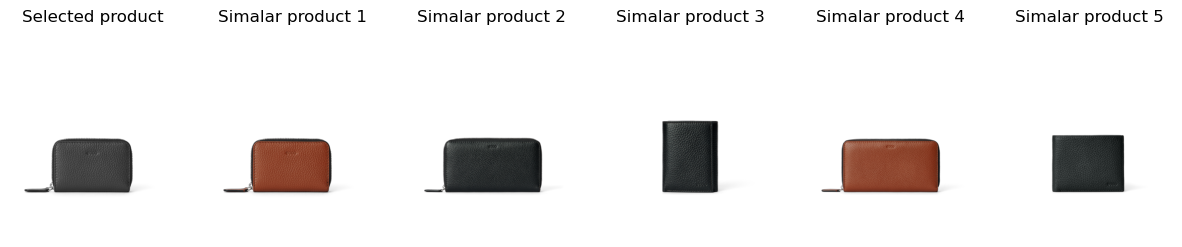

In [29]:
visualize_similar_items(item_index=3245, top_n=5)

Selected product name: ECCO CARD CASE ZIPPED PEBBLED


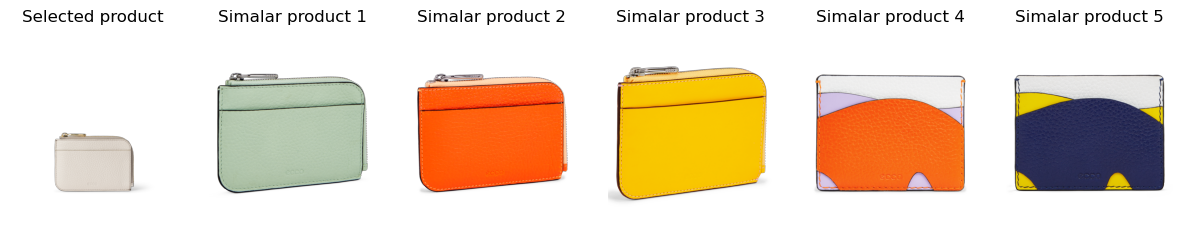

In [30]:
visualize_similar_items(item_index=1234, top_n=5)

Selected product name: ECCO HELSINKI 2


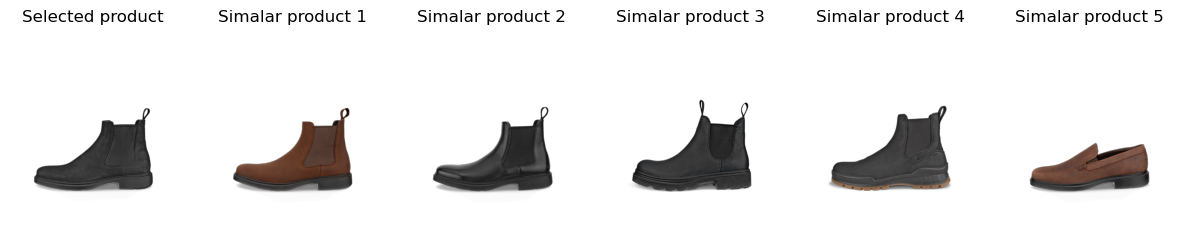

In [31]:
visualize_similar_items(item_index=835, top_n=5)

Selected product name: ECCO Anine Ballerinas


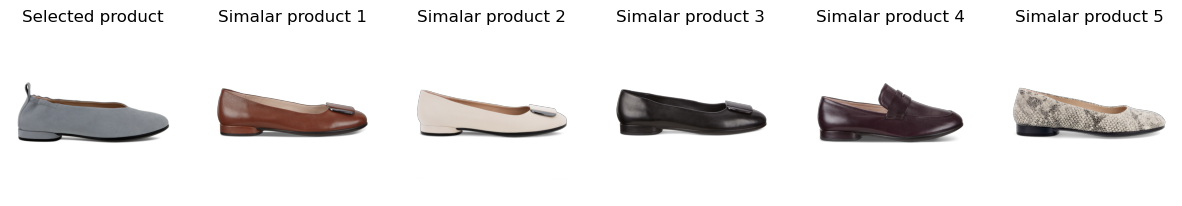

In [32]:
visualize_similar_items(item_index=2111, top_n=5)

Selected product name: ECCO CITYTRAY


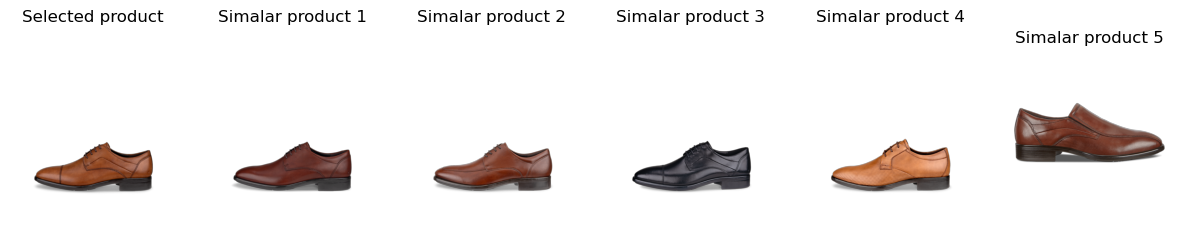

In [33]:
visualize_similar_items(item_index=1133, top_n=5)

We can see that such approach works, but then I got an idea to try some models which will take into account images of products instead of features. And after all experiments I assume best model be some combination of both approaches. Let's go and proceed with images for recomendations.

## Getting recommendation based on images

Let's download all images first

In [47]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from timm import create_model
from tqdm import tqdm
import wandb

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

output_dir = "images"

In [ ]:
os.makedirs(output_dir, exist_ok=True)

def download_image(url, save_path):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
    except Exception as e:
        print(f"Ошибка при скачивании {url}: {e}")

# Скачиваем изображения
for _, row in tqdm(cleaned_df.iterrows(), total=cleaned_df.shape[0]):
    image_url = row['image']
    object_id = row['objectID']
    save_path = os.path.join(output_dir, f"{object_id}.jpg")
    download_image(image_url, save_path)

Let's proceed with few different models and try to extract features from images. We also will use `Wandb` to log results

In [48]:
def extract_features(model, image_path, transform):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features = model(image)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [49]:
def get_similar_items_by_image(similarity_matrix, object_ids, item_index, top_n=5):
    similar_items = list(enumerate(similarity_matrix[item_index]))
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)
    return [(object_ids[idx], score) for idx, score in similar_items[1:top_n+1]]


In [53]:
import torch

def run_experiment(model_name, transform, cleaned_df, output_dir, save_dir="saved_models", top_n=5):
    """
    Запускает эксперимент, возвращает модель и данные, сохраняет их для дальнейшего использования.
    """
    wandb.init(project="image-similarity", name=f"{model_name}_experiment")

    # Создание папки для сохранения моделей
    os.makedirs(save_dir, exist_ok=True)

    print(f"Loading model: {model_name}")
    model = create_model(model_name, pretrained=True, num_classes=0)
    model.eval()

    # Извлечение эмбеддингов
    start_time = time.time()
    embeddings = {}
    for _, row in tqdm(cleaned_df.iterrows(), total=cleaned_df.shape[0]):
        object_id = row['objectID']
        image_path = os.path.join(output_dir, f"{object_id}.jpg")
        features = extract_features(model, image_path, transform)
        if features is not None:
            embeddings[object_id] = features
    elapsed_time = time.time() - start_time
    print(f"Execution time for {model_name}: {elapsed_time:.2f} sec")

    # Создаём матрицу признаков и рассчитываем схожесть
    object_ids = list(embeddings.keys())
    feature_matrix = np.array(list(embeddings.values()))
    similarity_matrix = cosine_similarity(feature_matrix)

    # Средняя схожесть
    avg_similarity = np.mean([similarity_matrix[i].max() for i in range(len(object_ids))])

    # Логгирование в WandB
    wandb.log({
        "model": model_name,
        "elapsed_time": elapsed_time,
        "average_similarity": avg_similarity,
    })

    # Сохраняем модель, эмбеддинги и object_ids
    torch.save({
        "model_state_dict": model.state_dict(),
        "object_ids": object_ids,
        "feature_matrix": feature_matrix
    }, os.path.join(save_dir, f"{model_name}_model.pth"))

    print(f"Model and data saved to {save_dir}/{model_name}_model.pth")

    wandb.finish()

    return model, similarity_matrix, object_ids, feature_matrix


In [54]:
# Список моделей
models = ["resnet50", "efficientnet_b0", "mobilenetv2_100"]

# Результаты для каждой модели
experiment_results = {}

for model_name in models:
    print(f"Running experiment for model: {model_name}")
    model, similarity_matrix, object_ids, feature_matrix = run_experiment(
        model_name, transform, cleaned_df, output_dir
    )
    experiment_results[model_name] = {
        "model": model,
        "similarity_matrix": similarity_matrix,
        "object_ids": object_ids,
        "feature_matrix": feature_matrix,
    }


Running experiment for model: resnet50
Loading model: resnet50


  2%|█▋                                                                              | 69/3291 [00:10<07:41,  6.98it/s]

Error processing images\39057491252.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057491252.jpg'
Error processing images\39057490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057490000.jpg'
Error processing images\39053490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39053490000.jpg'


 38%|█████████████████████████████▋                                                | 1252/3291 [03:50<06:47,  5.00it/s]

Error processing images\910781890000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\910781890000.jpg'


 72%|███████████████████████████████████████████████████████▊                      | 2356/3291 [08:03<03:51,  4.03it/s]

Error processing images\905906090641.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\905906090641.jpg'


 72%|████████████████████████████████████████████████████████▍                     | 2383/3291 [08:10<04:06,  3.68it/s]

Error processing images\908527690833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527690833.jpg'
Error processing images\908527590833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527590833.jpg'


 74%|█████████████████████████████████████████████████████████▍                    | 2423/3291 [08:19<03:43,  3.89it/s]

Error processing images\908551990832.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551990832.jpg'


 74%|█████████████████████████████████████████████████████████▌                    | 2428/3291 [08:20<03:27,  4.16it/s]

Error processing images\908551690036.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551690036.jpg'


 74%|█████████████████████████████████████████████████████████▊                    | 2437/3291 [08:22<03:41,  3.85it/s]

Error processing images\908547500101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908547500101.jpg'


 75%|██████████████████████████████████████████████████████████▏                   | 2455/3291 [08:26<03:06,  4.48it/s]

Error processing images\908525890011.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908525890011.jpg'


 76%|███████████████████████████████████████████████████████████▏                  | 2498/3291 [08:38<03:11,  4.14it/s]

Error processing images\908558490250.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908558490250.jpg'


 77%|███████████████████████████████████████████████████████████▋                  | 2518/3291 [08:43<03:12,  4.01it/s]

Error processing images\903401700101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903401700101.jpg'


 77%|███████████████████████████████████████████████████████████▊                  | 2523/3291 [08:44<02:55,  4.39it/s]

Error processing images\904440100101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\904440100101.jpg'
Error processing images\903363000100.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903363000100.jpg'


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3132/3291 [11:12<00:35,  4.49it/s]

Error processing images\47075301001.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47075301001.jpg'
Error processing images\47073301646.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47073301646.jpg'


100%|██████████████████████████████████████████████████████████████████████████████| 3291/3291 [11:47<00:00,  4.65it/s]


Execution time for resnet50: 707.01 sec
Model and data saved to saved_models/resnet50_model.pth


average_similarity,▁▁▁
elapsed_time,█▁▇
average_similarity,1
elapsed_time,707.00827
model,resnet50


Running experiment for model: efficientnet_b0


wandb: Currently logged in as: maks88sgt (maks88sgt-hse-university). Use `wandb login --relogin` to force relogin


Loading model: efficientnet_b0


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

C:\Users\Maksim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Maksim\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
  2%|█▋                                                                              | 69/3291 [00:08<08:12, 

Error processing images\39057491252.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057491252.jpg'
Error processing images\39057490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057490000.jpg'
Error processing images\39053490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39053490000.jpg'


 38%|█████████████████████████████▋                                                | 1252/3291 [02:58<05:49,  5.83it/s]

Error processing images\910781890000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\910781890000.jpg'


 72%|███████████████████████████████████████████████████████▊                      | 2356/3291 [05:48<02:25,  6.41it/s]

Error processing images\905906090641.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\905906090641.jpg'


 72%|████████████████████████████████████████████████████████▍                     | 2383/3291 [05:53<02:44,  5.50it/s]

Error processing images\908527690833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527690833.jpg'
Error processing images\908527590833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527590833.jpg'


 74%|█████████████████████████████████████████████████████████▍                    | 2423/3291 [05:59<02:18,  6.29it/s]

Error processing images\908551990832.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551990832.jpg'


 74%|█████████████████████████████████████████████████████████▌                    | 2428/3291 [06:00<02:15,  6.36it/s]

Error processing images\908551690036.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551690036.jpg'


 74%|█████████████████████████████████████████████████████████▊                    | 2437/3291 [06:01<02:19,  6.13it/s]

Error processing images\908547500101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908547500101.jpg'


 75%|██████████████████████████████████████████████████████████▏                   | 2455/3291 [06:03<01:48,  7.71it/s]

Error processing images\908525890011.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908525890011.jpg'


 76%|███████████████████████████████████████████████████████████▏                  | 2498/3291 [06:11<02:08,  6.18it/s]

Error processing images\908558490250.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908558490250.jpg'


 77%|███████████████████████████████████████████████████████████▋                  | 2518/3291 [06:15<02:56,  4.38it/s]

Error processing images\903401700101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903401700101.jpg'


 77%|███████████████████████████████████████████████████████████▊                  | 2523/3291 [06:15<02:34,  4.97it/s]

Error processing images\904440100101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\904440100101.jpg'
Error processing images\903363000100.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903363000100.jpg'


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3132/3291 [08:01<00:24,  6.36it/s]

Error processing images\47075301001.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47075301001.jpg'
Error processing images\47073301646.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47073301646.jpg'


100%|██████████████████████████████████████████████████████████████████████████████| 3291/3291 [08:28<00:00,  6.48it/s]


Execution time for efficientnet_b0: 508.20 sec
Model and data saved to saved_models/efficientnet_b0_model.pth


average_similarity,▁
elapsed_time,▁
average_similarity,1
elapsed_time,508.2046
model,efficientnet_b0


Running experiment for model: mobilenetv2_100


Loading model: mobilenetv2_100


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

C:\Users\Maksim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Maksim\.cache\huggingface\hub\models--timm--mobilenetv2_100.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
  2%|█▋                                                                              | 69/3291 [00:08<07:38, 

Error processing images\39057491252.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057491252.jpg'
Error processing images\39057490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39057490000.jpg'
Error processing images\39053490000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\39053490000.jpg'


 38%|█████████████████████████████▋                                                | 1252/3291 [03:14<07:46,  4.37it/s]

Error processing images\910781890000.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\910781890000.jpg'


 72%|███████████████████████████████████████████████████████▊                      | 2356/3291 [06:28<02:27,  6.33it/s]

Error processing images\905906090641.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\905906090641.jpg'


 72%|████████████████████████████████████████████████████████▍                     | 2383/3291 [06:32<02:40,  5.65it/s]

Error processing images\908527690833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527690833.jpg'
Error processing images\908527590833.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908527590833.jpg'


 74%|█████████████████████████████████████████████████████████▍                    | 2423/3291 [06:38<02:19,  6.21it/s]

Error processing images\908551990832.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551990832.jpg'


 74%|█████████████████████████████████████████████████████████▌                    | 2428/3291 [06:39<02:10,  6.60it/s]

Error processing images\908551690036.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908551690036.jpg'


 74%|█████████████████████████████████████████████████████████▊                    | 2437/3291 [06:40<02:25,  5.86it/s]

Error processing images\908547500101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908547500101.jpg'


 75%|██████████████████████████████████████████████████████████▏                   | 2455/3291 [06:43<01:53,  7.39it/s]

Error processing images\908525890011.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908525890011.jpg'


 76%|███████████████████████████████████████████████████████████▏                  | 2498/3291 [06:50<02:03,  6.43it/s]

Error processing images\908558490250.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\908558490250.jpg'


 77%|███████████████████████████████████████████████████████████▋                  | 2518/3291 [06:53<02:01,  6.38it/s]

Error processing images\903401700101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903401700101.jpg'


 77%|███████████████████████████████████████████████████████████▊                  | 2523/3291 [06:54<01:40,  7.66it/s]

Error processing images\904440100101.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\904440100101.jpg'
Error processing images\903363000100.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\903363000100.jpg'


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3132/3291 [08:36<00:22,  7.04it/s]

Error processing images\47075301001.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47075301001.jpg'
Error processing images\47073301646.jpg: [Errno 2] No such file or directory: 'C:\\Users\\Maksim\\LSML Final Project\\images\\47073301646.jpg'


100%|██████████████████████████████████████████████████████████████████████████████| 3291/3291 [08:59<00:00,  6.10it/s]


Execution time for mobilenetv2_100: 539.71 sec
Model and data saved to saved_models/mobilenetv2_100_model.pth


average_similarity,▁
elapsed_time,▁
average_similarity,1
elapsed_time,539.71325
model,mobilenetv2_100


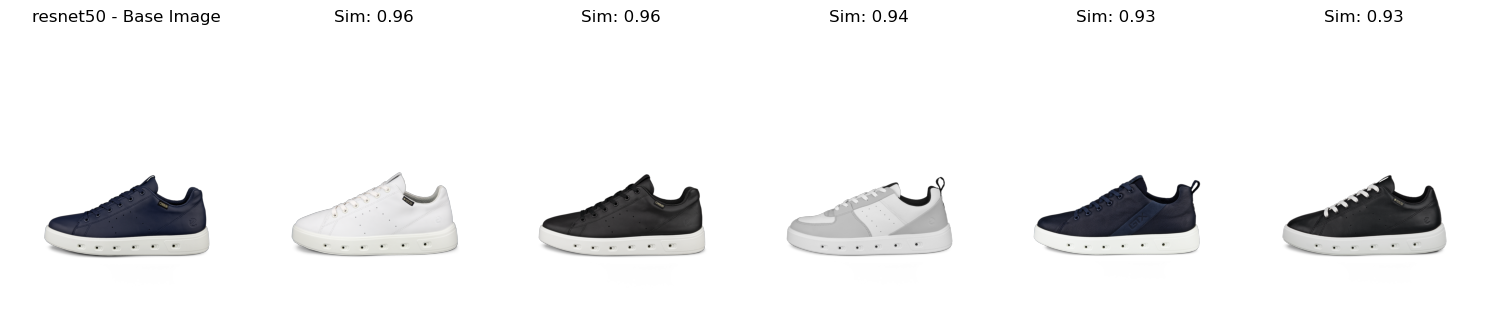

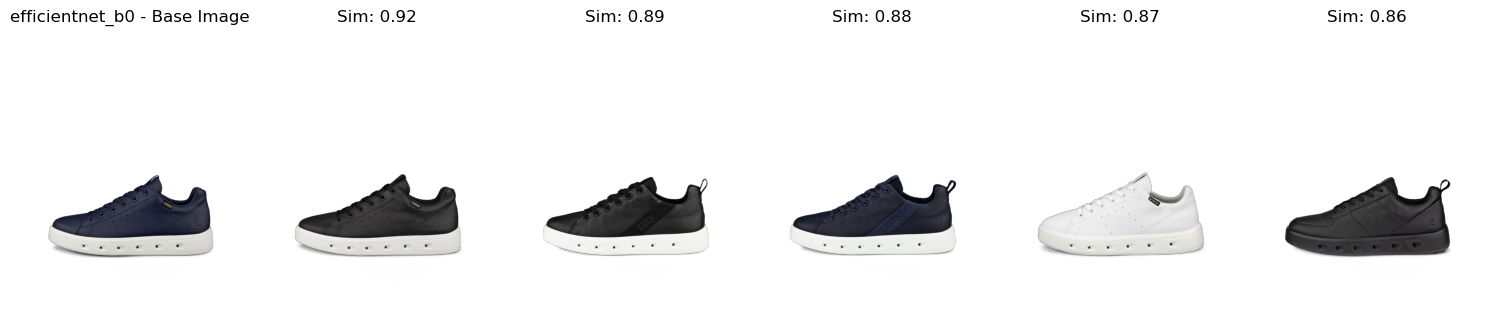

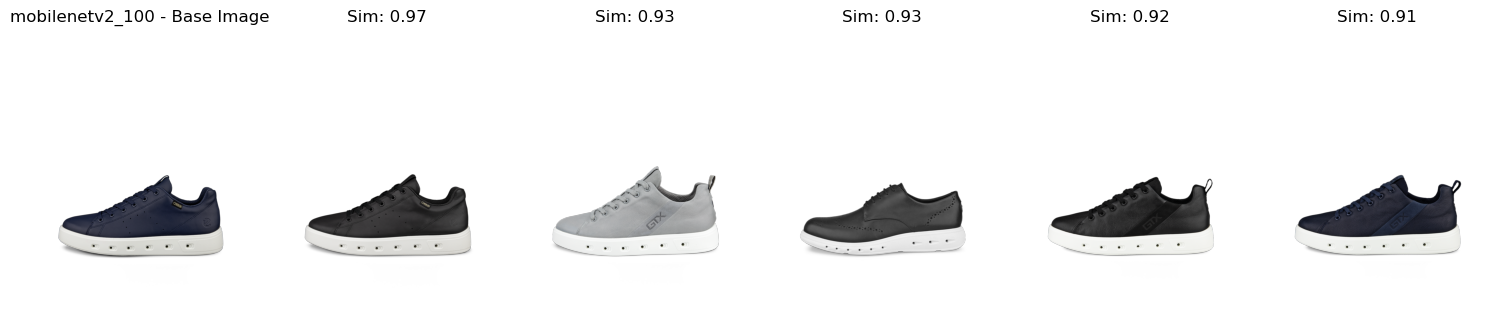

In [56]:
def log_and_visualize_comparison(experiment_results, test_index=123, top_n=5):

    for model_name, result in experiment_results.items():
        similarity_matrix = result["similarity_matrix"]
        object_ids = result["object_ids"]

        similar_items = get_similar_items_by_image(similarity_matrix, object_ids, test_index, top_n)

        wandb.init(project="image-similarity-comparison", name=f"{model_name}_comparison")
        wandb.log({
            "base_image": wandb.Image(f"{output_dir}/{object_ids[test_index]}.jpg"),
            "similar_images": [
                wandb.Image(f"{output_dir}/{obj_id}.jpg", caption=f"Similarity: {score:.2f}")
                for obj_id, score in similar_items
            ],
        })
        wandb.finish()

        plt.figure(figsize=(15, 5))
        base_image_path = os.path.join(output_dir, f"{object_ids[test_index]}.jpg")
        base_image = Image.open(base_image_path)

        plt.subplot(1, top_n + 1, 1)
        plt.imshow(base_image)
        plt.axis('off')
        plt.title(f"{model_name} - Base Image")

        for i, (obj_id, score) in enumerate(similar_items):
            similar_image_path = os.path.join(output_dir, f"{obj_id}.jpg")
            try:
                plt.subplot(1, top_n + 1, i + 2)
                similar_image = Image.open(similar_image_path)
                plt.imshow(similar_image)
                plt.axis('off')
                plt.title(f"Sim: {score:.2f}")
            except Exception as e:
                print(f"Error loading image {obj_id}: {e}")
        
        plt.tight_layout()
        plt.show()

log_and_visualize_comparison(experiment_results, test_index=123, top_n=5)

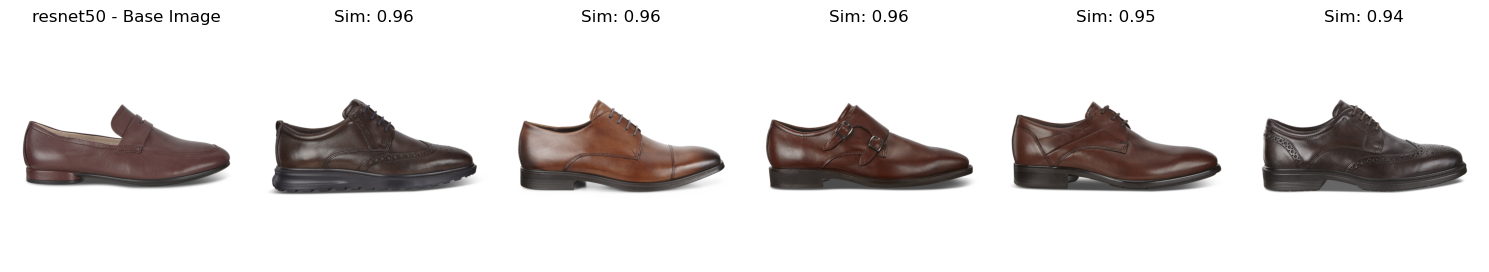

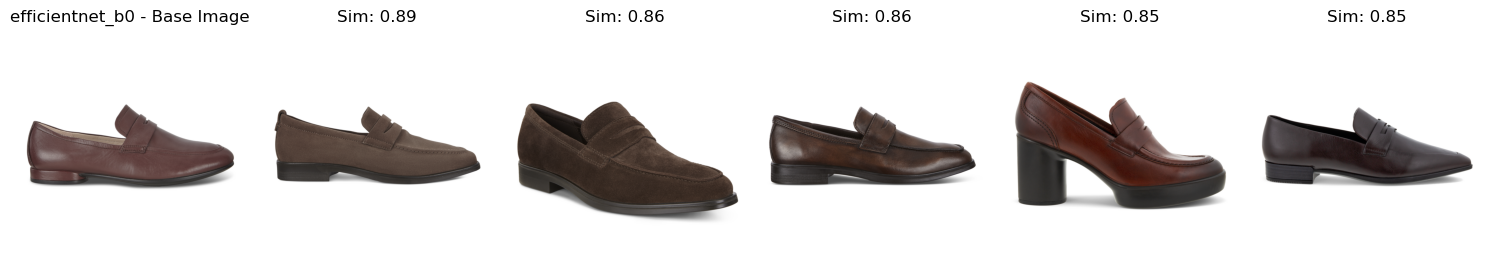

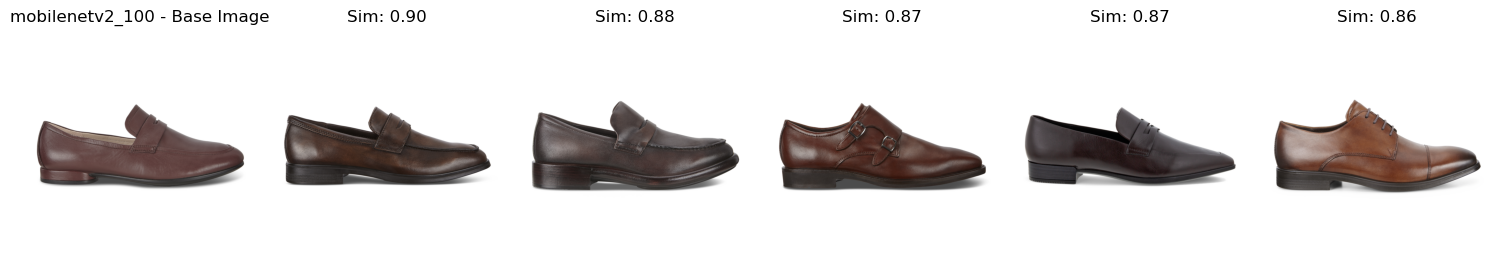

In [58]:
log_and_visualize_comparison(experiment_results, test_index=2111, top_n=5)

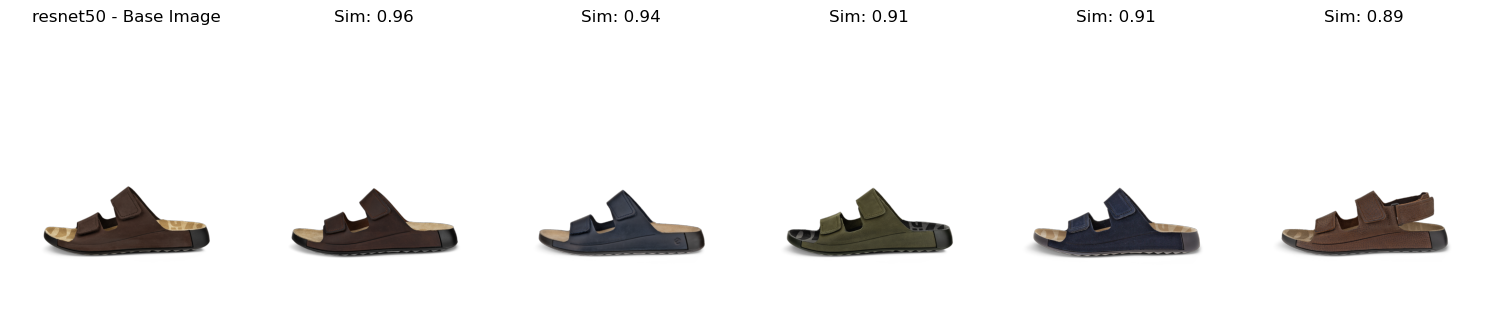

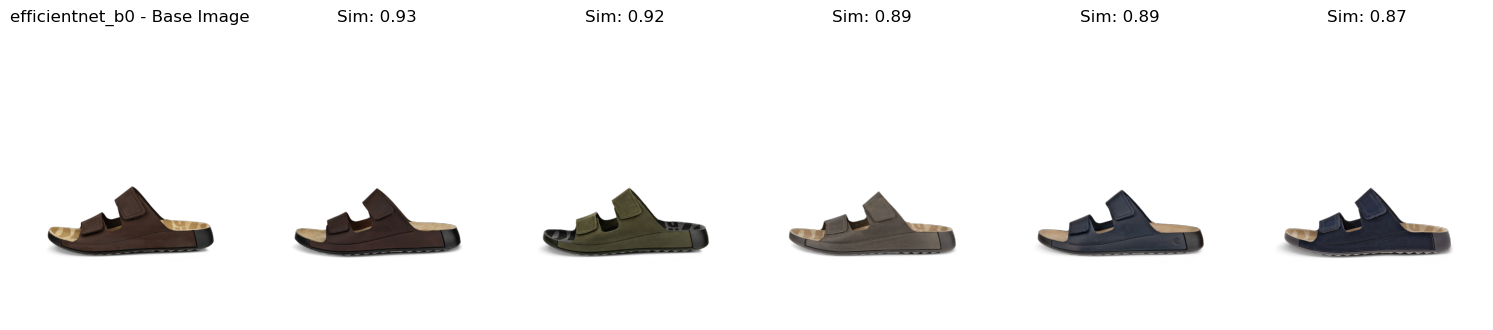

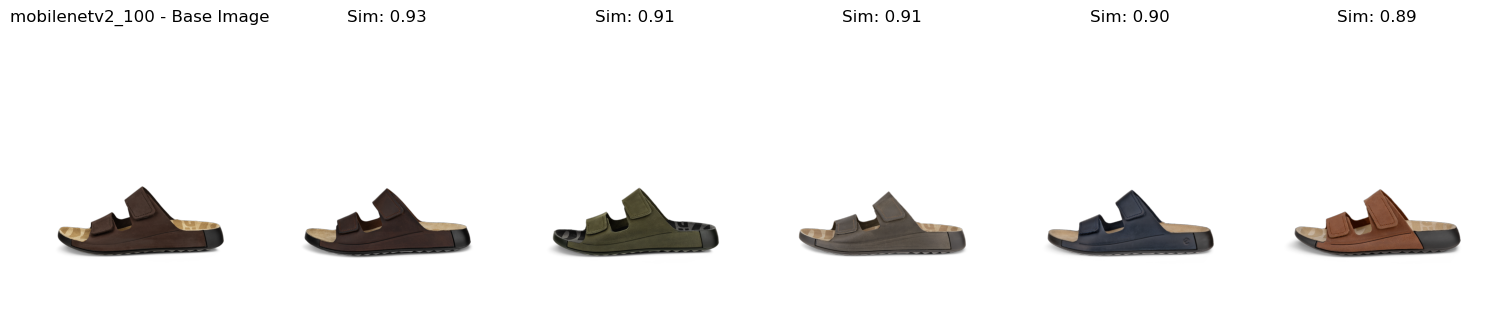

In [59]:
log_and_visualize_comparison(experiment_results, test_index=1133, top_n=5)

We can see that results is quite good. For my Master's thesis I'll try to create more advanced system. But now we can proceed with web service using models

## Web service

After models investigation I did simple web service to allow user to find similar products. It contains FE part (simple React.js app) and BE - FastAPI server. Server code is located in `./server` folder, FE part in `./image-similarity-app`.

### Server



#### **Description**
This is a **FastAPI** server application that provides image-based product recommendations for the ECCO product catalog.  
It uses pre-trained models to find visually similar products based on their images.

---

##### Supported Models:
- **ResNet50**
- **EfficientNet B0**
- **MobileNetV2 100**

The application offers:
1. A list of all products with pagination.
2. Recommendations for visually similar products based on an input product.

---

#### **Technologies**
- **FastAPI** – for building the API.
- **PyTorch** – to load and use pre-trained models.
- **Pandas** – for data management.
- **scikit-learn** – for cosine similarity calculation.
- **CORS Middleware** – to allow communication with a front-end client.
- **Docker** – to containerize the application.

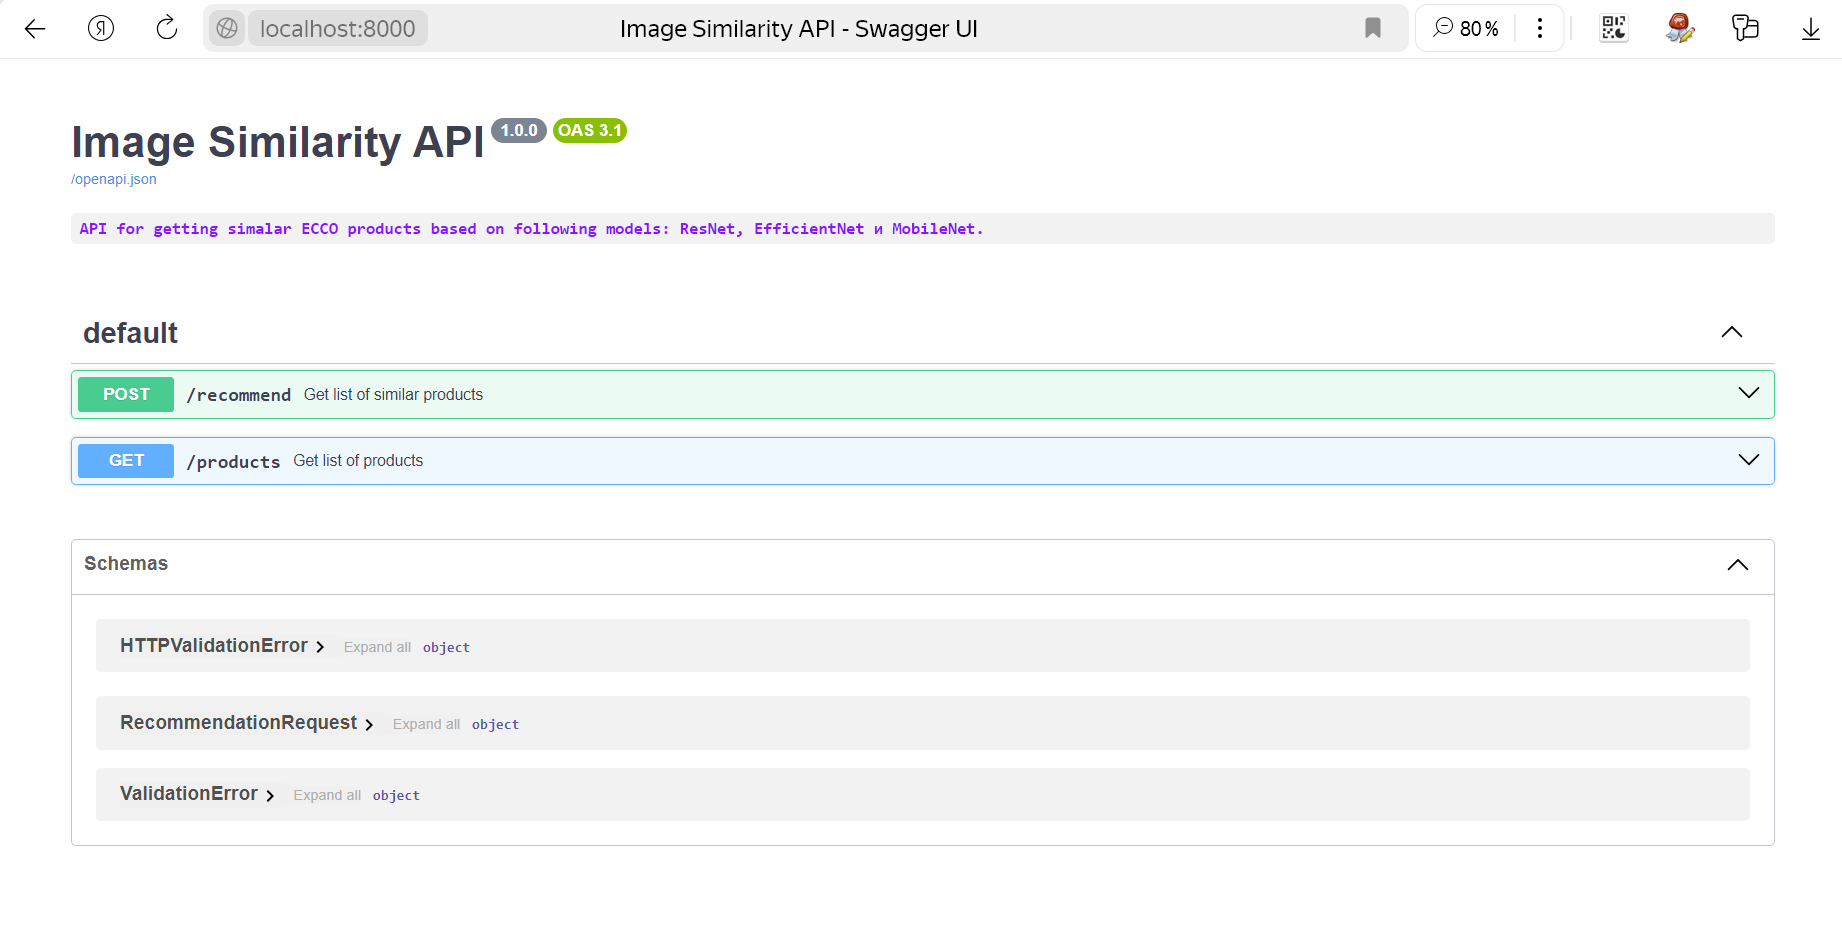

### FE part

#### **Description**
This is a **React** front-end application for displaying products from the ECCO product catalog and retrieving visually similar products.  
The application interacts with the **Image Similarity API** server to fetch data and display product recommendations.

---

#### **Features**
1. **Product Listing**: Displays a list of products with images, names, and basic details.
2. **Product Recommendation**: Allows users to select a product and view visually similar products.
3. **Pagination**: Supports navigation through the product list with pagination.

---

#### **Technologies**
- **React** – Front-end library for building the user interface.
- **React Router** – For navigation between pages.
- **Axios** – For making API calls.
- **CSS Modules** – For styling the components.
- **Docker** – For containerizing the client application.

---

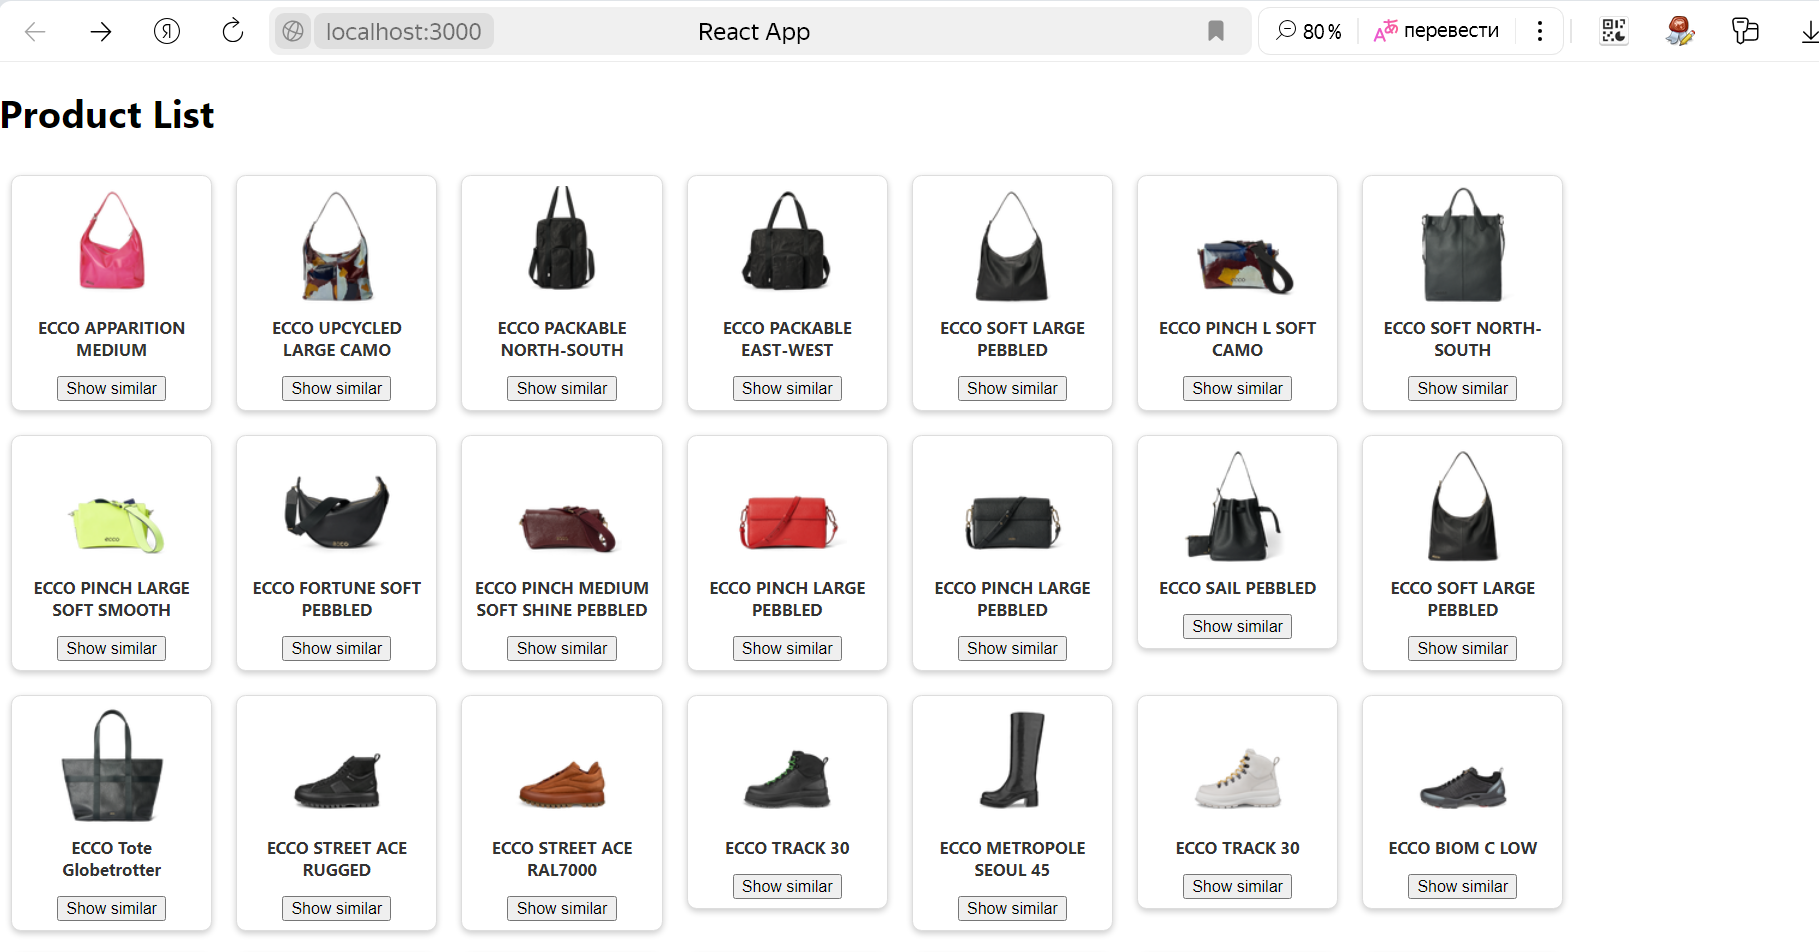

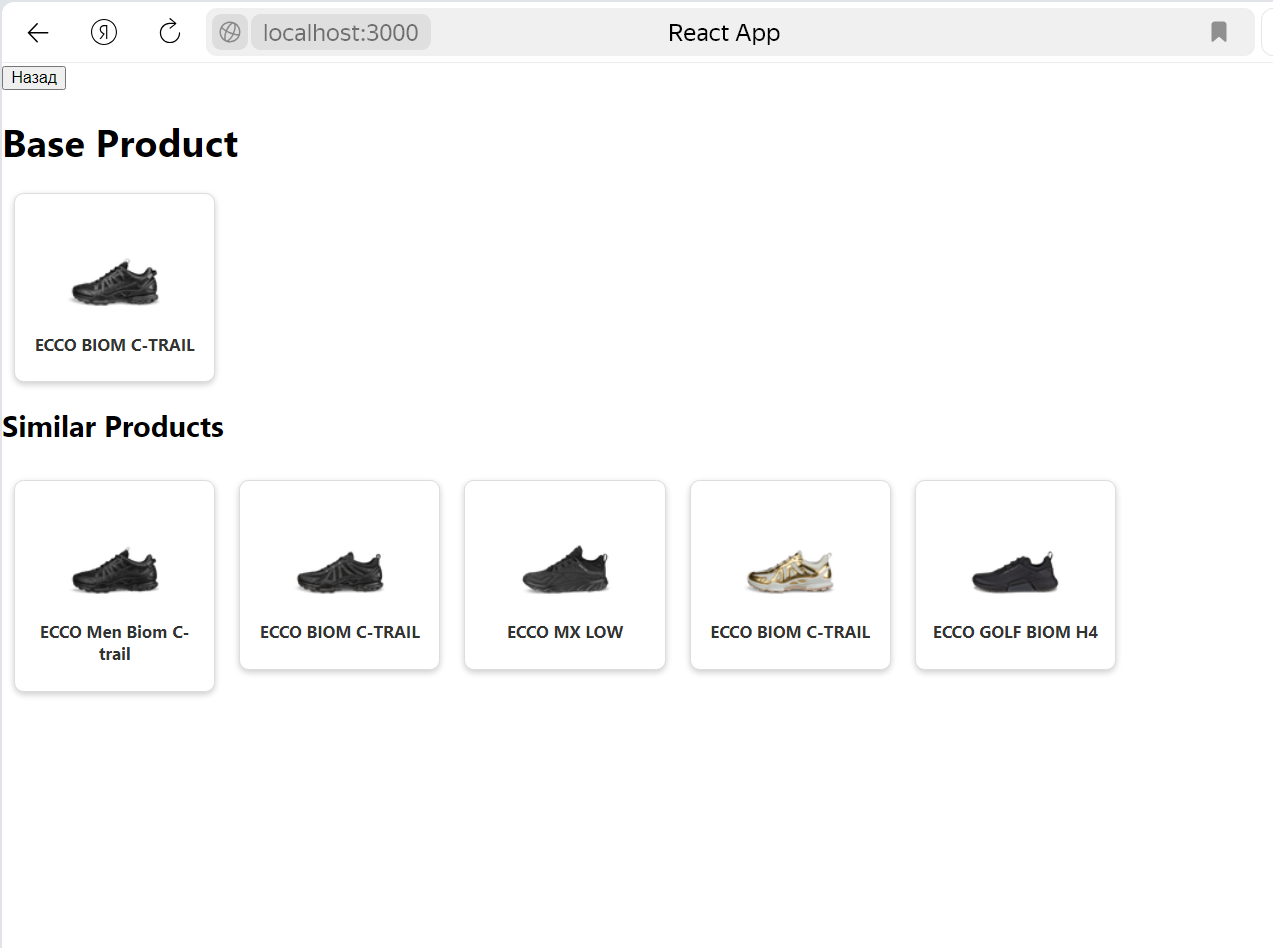

## Deployment

For both FE and BE parts I prepared Dockerfiles. On the top level also added docker-compose.yaml file which allows to build and run containerized service. Below you will see the result of docker-compose. If necessary I can deploy service somewhere to make it available from WWW. 

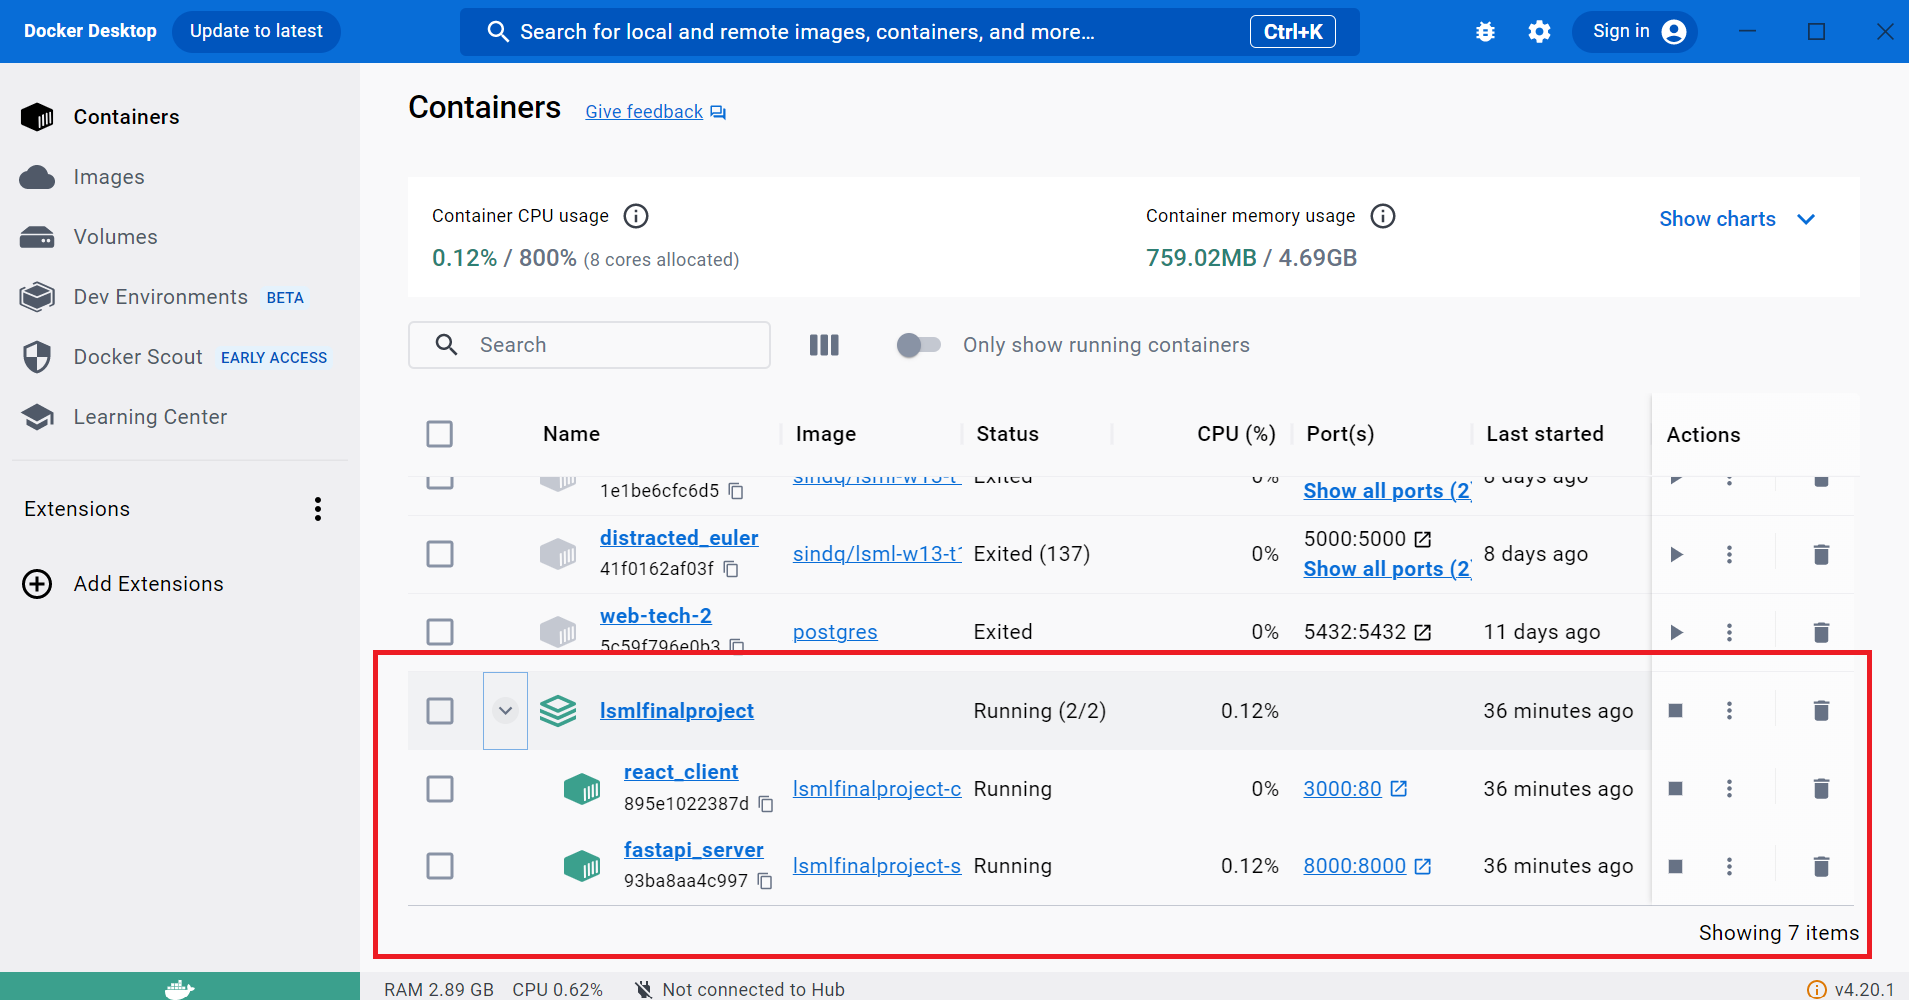

## Conclusions

This project explored different approaches to building an image-based product recommendation system for ECCO's catalog. By testing pre-trained models (ResNet50, EfficientNet B0, MobileNetV2), developing a FastAPI backend, and integrating it with a React frontend, I successfully created a functional system. The results will serve as a foundation for my master’s thesis.

#### Key Takeaways
ResNet50 and EfficientNet B0 provided better visual consistency, while MobileNetV2 excelled in speed, making it suitable for real-time applications.
The API and client were containerized using Docker, ensuring portability and scalability.

#### Future Improvements
* Data Augmentation: Enrich datasets to improve model performance.
* Hybrid Recommendations: Combine visual data with text and metadata for better accuracy.
* User-Uploaded Images: Enable recommendations based on custom image inputs.
* Model Optimization: Fine-tune pre-trained models and explore lightweight alternatives for real-time use.
* Enhanced UX: Add filtering, sorting, and richer product details on the frontend.

This system demonstrates potential for further refinement and application in retail, providing a solid basis for future research and practical use.